# Predicting Zillow Prices
### Nick Lind

This notebook was created to serve as an illustrative guide to the data science workflow.

## Step 1: Framing the problem and looking at the bigger picture
1. Define the objective in business terms. What decision are you trying to inform? What problem are you trying to solve?
2. How will your solution be used? Who is your user?
3. What are the current solutions/workarounds (if any)?
4. What type of learning problem are we dealing with (supervised, unsupervised, etc.)?
5. How should performance be measured? Is the performance measure aligned with the business objective?
7. What would be the minimum performance needed to reach the business objective?
8. What are comparable problems? Can you reuse experience or tools?

## Step 2: Procure the data
1. List the data you need and how much you need.
2. Find and document where you can get that data.
3. Check how much space it will take.
4. Check legal obligations, and get authorization if necessary.
5. Get access authorizations.
6. Create a workspace (with enough storage space).
7. Get the data.
8. Double-check for biases.
8. Convert the data to a format you can easily manipulate (without changing the data itself).
9. Ensure sensitive information is deleted or protected (e.g., anonymized).
10. Check the size and type of data (time series, sample, geographical, etc.).

### Data Types
For most data science problems in Python, we'll use:
    * Lists
    * Series (NumPy)
    * Arrays (NumPy)
    * DataFrames (Pandas)

### Import Data & Packages
First, we import our dataset as well as the relevant packages we'll need for our analysis.

In [1]:
# Import packages
import numpy as np
import pandas as pd
from numpy import loadtxt
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense

import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import ggplot as ggplot
color = sns.color_palette()
import folium


# Set parameters
path = "C:/Users/nthor/Documents/GitHub/Predicting_Property_Value_Zillow/data/"
loc_properties = "properties_2016.csv"
loc_train = "train_2016_v2.csv"
trainingsize = .8

C:\Users\nthor\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.
C:\Users\nthor\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\nthor\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Users\nthor\Anaconda3\lib\site-packages\statsmode

In [2]:
# Import files
transactions = pd.read_csv(path + loc_train, delimiter=',', parse_dates=["transactiondate"])
properties = pd.read_csv(path + loc_properties, delimiter=',')

C:\Users\nthor\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's take a look at our two datasets.

In [3]:
# Examine properties set
properties.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [4]:
# Examine list of sold homes
transactions.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


Finally, let's join our datasets together before digging-in to our analysis.

In [5]:
# Merge datasets
merged = pd.merge(properties, transactions, on=['parcelid','parcelid'])
# Fix latitude and longitude coordinates
merged.latitude = merged.latitude / 1e6
merged.longitude = merged.longitude / 1e6

### Examine Biases

Before moving forward, we should address the following questions:
    1. Did we introduce bias into the dataset during sampling?
    2. Do we have enough observations to establish causal inference?
    3. Do we have time-series data extending back far enough to detect regression to the mean?

## Step 3: Explore the data
3. Study each attribute and its characteristics:
    * Name
    * Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
    * Percent of missing values
    * Noisiness and type of noise (stochastic, outliers, rounding errors, etc.)
    * Possibly useful for the task?
    * Type of distribution (Gaussian, uniform, logarithmic, etc.)
4. For supervised learning tasks, identify the target attribute(s).
5. Visualize the data.
6. Study the correlations between attributes.
7. Study how you would solve the problem manually.
8. Identify the promising transformations you may want to apply.
9. Identify extra data that would be useful (go back to “Get the Data”).
10. Document what you have learned.

### Missing Values

We notice a few missing values in our .head() calls; let's examine the percent of values in each column that are null.

In [6]:
# Find percent of missing values in each column
merged.isnull().sum()/len(merged)*100

parcelid                         0.000000
airconditioningtypeid           68.118527
architecturalstyletypeid        99.710883
basementsqft                    99.952368
bathroomcnt                      0.000000
bedroomcnt                       0.000000
buildingclasstypeid             99.982276
buildingqualitytypeid           36.456383
calculatedbathnbr                1.309333
decktypeid                      99.271116
finishedfloor1squarefeet        92.405428
calculatedfinishedsquarefeet     0.732207
finishedsquarefeet12             5.183052
finishedsquarefeet13            99.963445
finishedsquarefeet15            96.052063
finishedsquarefeet50            92.405428
finishedsquarefeet6             99.533647
fips                             0.000000
fireplacecnt                    89.358073
fullbathcnt                      1.309333
garagecarcnt                    66.837995
garagetotalsqft                 66.837995
hashottuborspa                  97.380227
heatingorsystemtypeid           37

Visualized differently:

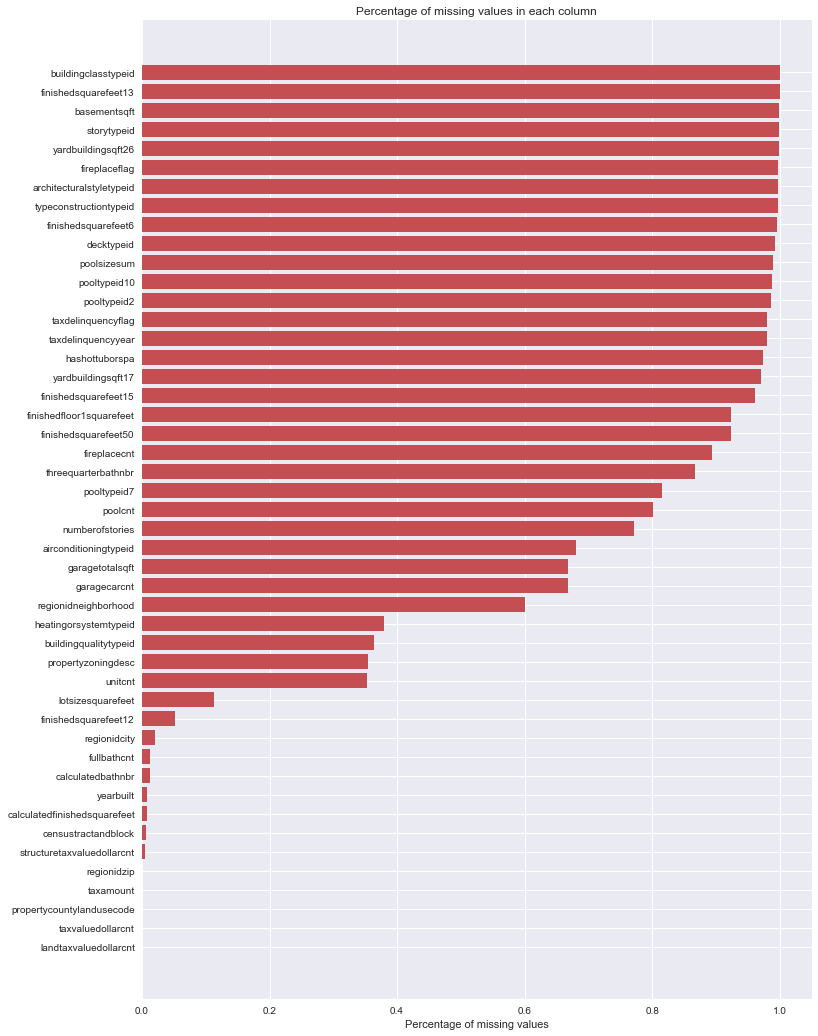

In [7]:
missing_df = merged.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df['missing_ratio'] = missing_df['missing_count'] / merged.shape[0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_ratio.values, color=color[2])
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Percentage of missing values")
ax.set_title("Percentage of missing values in each column")
plt.show()

Unsurpisingly, many of our more obscure features (e.g., *poolcnt*) are blank for the vast majority of homes. Thankfully, our dependent variable, *logerror*, is never null. 

How should we handle these nulls? Generally, we do one of the following:
* Use a model that can deal with nulls (random forest)
* Drop the nulls
* Predict the nulls

### Logerror

Let's start by examining the value that we're responsible for predicting.

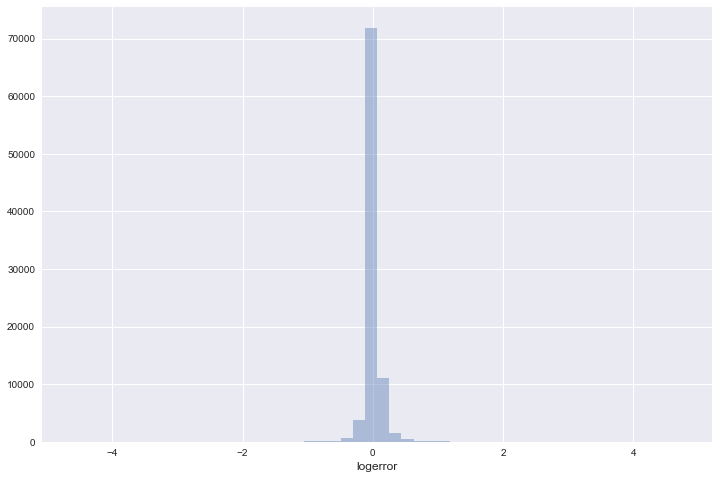

In [8]:
plt.figure(figsize=(12,8))
sns.distplot(merged.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

In [9]:
# Examine outliers
merged.logerror.describe()

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64

We have a few major outliers on either end of the spectrum. In general, the Zestimate seems to overshoot the actual sales price.

### Time Variables
Next, we explore how our transactions vary across time.

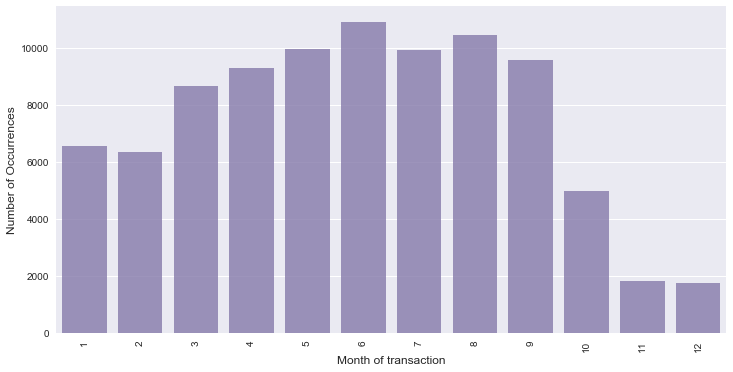

In [10]:
# Create month variable and accurate prediction indicator
merged['transaction_month'] = merged['transactiondate'].dt.month
merged['accurate_price'] = '0'
merged['accurate_price'].loc[(merged.logerror.values == 0)] == '1'



# Plot results
cnt_srs = merged.transaction_month.value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

Unsurprisingly, most real estate activity occurs during the spring and summer (when it's most convenient for the average American to move / relocate.

### Geographic Area

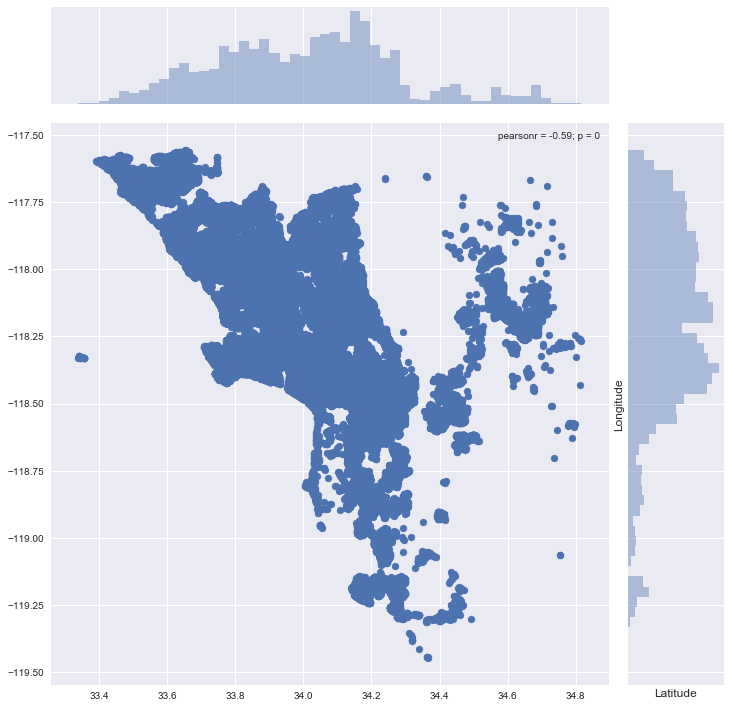

In [11]:
plt.figure(figsize=(12,12))
sns.jointplot(x=merged.latitude.values, y=merged.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

Sales made across three regions in California. Any pattern by region?

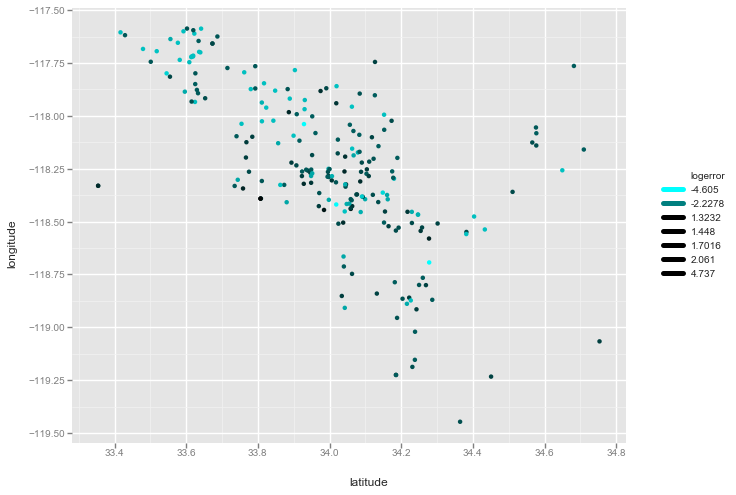

<ggplot: (-9223371941661763163)>

In [12]:
# Filter outliers > 8 std. dev. away and create array for plotting
filtered_pred = merged[abs(merged.logerror.values) > 8*np.std(merged.logerror.values)]
lat_long = np.transpose(np.array([filtered_pred.latitude, filtered_pred.longitude]))
lat = np.array([filtered_pred.latitude])
long = np.array([filtered_pred.longitude])

from ggplot import * 
ggplot(aes(x='latitude', y='longitude', color='logerror'), data= filtered_pred) + \
    geom_point() + \
    scale_color_gradient(low = 'aqua', high = 'black')

In [13]:
# Take average for folium map
avg_lat = sum(merged.latitude.values)/len(merged.latitude.values)
avg_long = sum(merged.longitude.values)/len(merged.longitude.values)

# Plot folium map
map_1 = folium.Map(location=[avg_lat, avg_long], zoom_start = 8)

for i in range(0, len(filtered_pred)):
    folium.CircleMarker([filtered_pred.latitude.iloc[i], filtered_pred.longitude.iloc[i]],
                        radius=5,
                        color='#3186cc',
                        fill_color='#3186cc',).add_to(map_1)
map_1

There does seem to be some grouping in our errors, paticularly around Huntington Park, Compton, and Mission Viejo. We may be able to improve our predictions by using clustering / dimensionality reduction techniques to generate new features.

### Geospatial Clustering

In [14]:
# Cluster by coordinates
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN
from geopy.distance import vincenty

dbscan = DBSCAN(eps=5/6371., min_samples=5, algorithm='ball_tree', metric='haversine') # 50 meters
dbscan.fit(np.radians(lat_long))

cluster_labels = dbscan.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([lat_long[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 7


When we filter our dataset to only include houses where *logerror* is outside two standard deviations, we seem to have 7 logical clusters using DBSCAN. We could use these clusters to classify new observations and create new features for our final model.

### Correlation Analysis

We use correlation analysis to explore the relationships between the various features in our dataset.

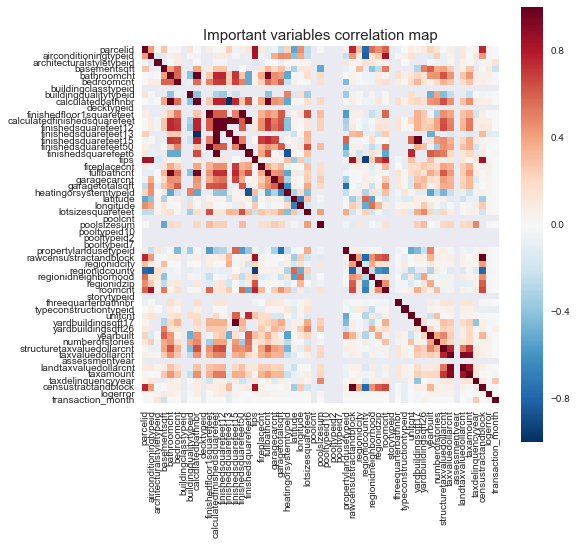

In [15]:
# Define heat map
corrmat = merged.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True, annot = False)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

Which x-variables are highly correlated with our predicted values?

In [16]:
corrmat.logerror[corrmat.logerror.values > .025]

C:\Users\nthor\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


parcelid                        0.027544
architecturalstyletypeid        0.044570
basementsqft                    0.098648
bathroomcnt                     0.066674
bedroomcnt                      0.041665
calculatedbathnbr               0.067080
calculatedfinishedsquarefeet    0.074351
finishedsquarefeet12            0.078631
finishedsquarefeet15            0.039680
fireplacecnt                    0.050074
fullbathcnt                     0.060977
garagecarcnt                    0.030169
garagetotalsqft                 0.028387
yearbuilt                       0.044450
numberofstories                 0.054582
structuretaxvaluedollarcnt      0.034373
taxvaluedollarcnt               0.031599
logerror                        1.000000
transaction_month               0.026840
Name: logerror, dtype: float64

In plain English, the following variables appear to be highly correlated with mistaken Zestimates:
* House / basement size
* Number of bathrooms
* Number of bedrooms
* Number of fireplaces
* Number of garage spaces
* Number of stories
* Newer apartments
* Taxes paid

In short, Zillow's estimates seem to inappropriately price large / lavish / new homes. Basement size appears to be particularly correlated to logerror; perhaps the algorithm doesn't accurately value large basements?

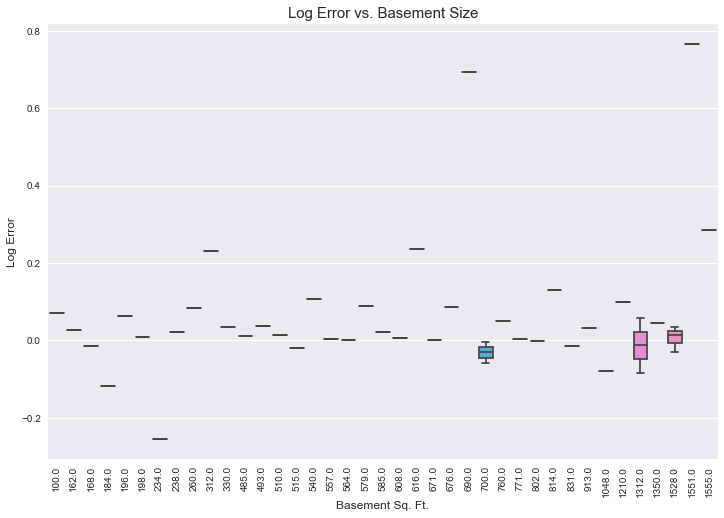

In [17]:
plt.figure(figsize=(12,8))
sns.boxplot(x="basementsqft", y="logerror", data = merged)
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Basement Sq. Ft.', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Log Error vs. Basement Size", fontsize=15)
plt.show()

We see a slight positive trend, with a greater degree of logerror variance near the end of the x-axis.

C:\Users\nthor\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


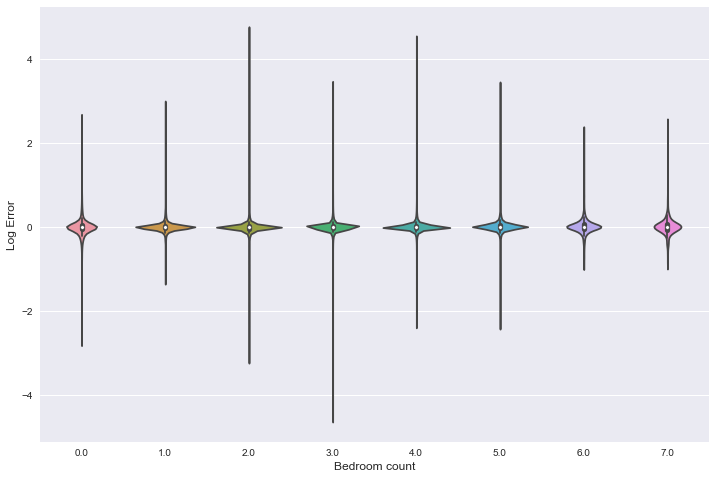

In [18]:
merged['bedroomcnt'].loc[merged['bedroomcnt']>7] = 7 # Set maximum number of bedrooms to seven
plt.figure(figsize=(12,8))
sns.violinplot(x='bedroomcnt', y='logerror', data=merged)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

Densely populated at zero, with slightly more spread at either end of the x-axis; studios and large mansions may be harder to accurately predict sales price.

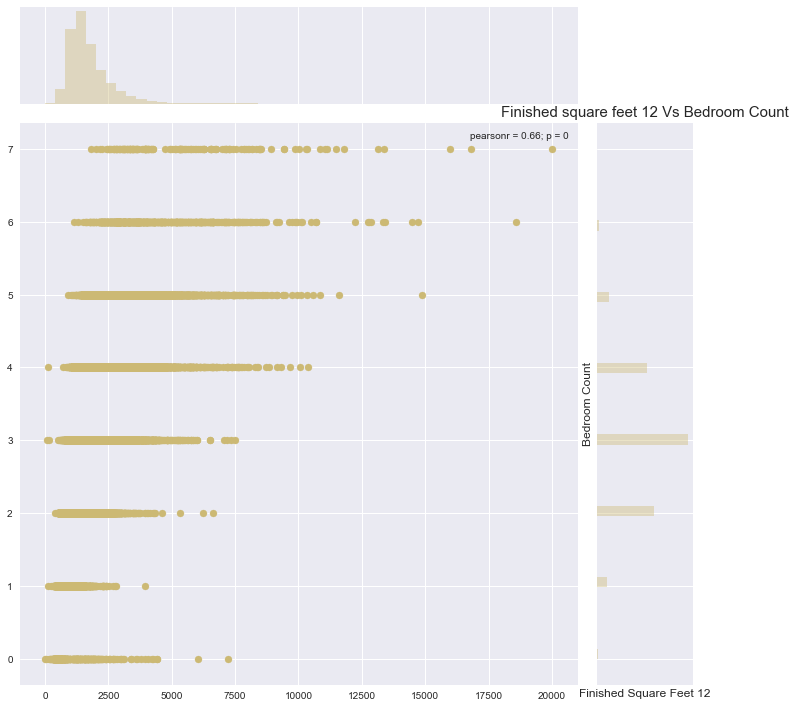

In [19]:
plt.figure(figsize=(6,6))
sns.jointplot(x=merged.finishedsquarefeet12.values, y=merged.bedroomcnt.values, size=10, color=color[4])
plt.ylabel('Bedroom Count', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Bedroom Count", fontsize=15)
plt.show()

Many of our exogeneous variables are likely to be correlated (as illustrated above), which we'll have to keep in mind as we select our features.

### Additional steps to consider
1. Some inputs should be treated as categorical variables instead of integers
2. Identify potential distributions for parametric modeling (Gaussian, etc.)
3. Decompose dates / times into the appropriate format(s)

## Step 4: Clean the data

1. Drop useless features / attributes.
2. Fill-in NA's.
3. Drop outliers that you can't explain.
4. Create binary flags.
5. Convert datatypes where necessary.

In [20]:
# split data into X and y while filling nulls with 0 and dropping a few categorical variables that we may want to add in later
X = merged.drop(['parcelid', 'logerror', 'transactiondate', 'transaction_month', 'accurate_price', 'propertycountylandusecode', 'propertyzoningdesc'], axis=1).fillna(0) # dropped for simplicity; generally you wouldn't want to drop variables without a strong rationale
y = merged['logerror']

# convert taxdelinquencyflag 'Y's into 1's
X.iloc[X[X['taxdelinquencyflag'] == 'Y'].index, X.columns.get_loc('taxdelinquencyflag')] = 1

# convert X to float
X = X.apply(pd.to_numeric)

## Step 5: Engineer features for modeling
* Discretize continuous features.
* Decompose features (e.g., categorical, date/time, etc.).
* Add promising transformations of features (e.g., log(x), sqrt(x), x^2, etc.).
* Aggregate features into promising new features.
* Brainstorm potentially predictive drivers and see what other data you can scrape / procure to improve your results.

For the purposes of this demo, we'll create a few simple features using abstractions of data we already have. In the real-world, you'll also want to 

In [21]:
#life of property
X['N-life'] = 2018 - X['yearbuilt']

#Does property have a garage, pool or hot tub and AC?
X['N-GarPoolAC'] = ((X['garagecarcnt']>0) & (X['pooltypeid10']>0) & (X['airconditioningtypeid']!=5))*1 

X["N-location"] = X["latitude"] + X["longitude"]
X["N-location-2"] = X["latitude"]*X["longitude"]
X["N-location-2round"] = X["N-location-2"].round(-4)

X["N-latitude-round"] = X["latitude"].round(-4)
X["N-longitude-round"] = X["longitude"].round(-4)

#Number of properties in the zip
zip_count = X['regionidzip'].value_counts().to_dict()
X['N-zip_count'] = X['regionidzip'].map(zip_count)

#Number of properties in the city
city_count = X['regionidcity'].value_counts().to_dict()
X['N-city_count'] = X['regionidcity'].map(city_count)

#Number of properties in the city
region_count = X['regionidcounty'].value_counts().to_dict()
X['N-county_count'] = X['regionidcounty'].map(city_count)

TODO: Create new features after exploring initial Random Forest results.

## Step 6: Pre-process data for modeling
* Split our dataset into test and training sets so we can test how well our model generalizes the future
* Standardize / normalize our features to improve processing time and dampen the effect of outliers
    * Standardization <- (x - mean)/st.dev
        * Rescales features so that they'll have the properties of the standard normal distribution
        * Data's mean becomes 0 and st.dev. Becomes 1
        * Better performance
        * Mostly used for Gaussian distributions
    * Normalization <- (X - Xmin)/(Xmax - Xmin)
        * Also called Min-Max Scaling
        * Causes you to lose some information in the data, especially concerning outliers
        * Forces values to fit between the range of 0 and 1
        * Good when you do not know the distribution of your data or you know it's not Gaussian

In [22]:
# Scale features
scaler = StandardScaler()
X = X.fillna(0)
X_s = scaler.fit_transform(X)
y_s = scaler.fit_transform(y.values.reshape(-1, 1))

# Split into test / training
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2, random_state=7)



## Step 7: Select key features

**Curse of Dimensionality**: Many problems that do not exist in low-dimensional space arise in high-dimensional space. As we add additional features into our model, the number of observations necessary to cover the potential state landscape scales exponentially.

Potential solutions include:
* Variable selection via LASSO, ElasticNet, Recursive Feature Elimination, etc.
* Dimensionality reduction via PCA, autoencoders, etc.
* Importance scores from gradient-boosted tree algorithms
* Using commen sense and correlation tables to eliminate nonsensical features
* Using regularization to select features

For linear models, we'd prefer to use Recursive Feature Selection, ElasticNet, and LASSO to identify the variables we care about (all available through glmnet in R or sk-learn in Python). When we use a boosted tree approach, there are more effective, built-in tools we can use to identify the features we care about.

### Principle Component Analysis
In our final output table below, the variables with the highest weights should be considered most important.

In [23]:
from sklearn.decomposition import PCA

# Extract features
pca = PCA(n_components=5)
fit = pca.fit(X_s)
# Summarize components
print("Explained Variance: ", fit.explained_variance_ratio_)

Explained Variance:  [ 0.15095033  0.11032224  0.07889111  0.04501444  0.04179534]


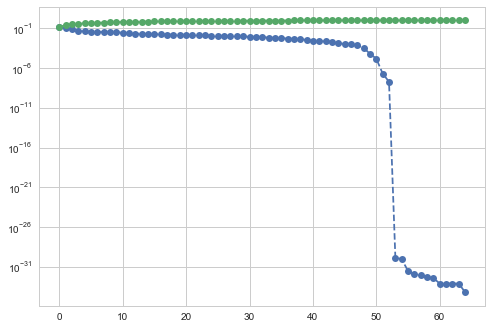

In [24]:
# Visualize results
pca_viz = PCA().fit(X_s);

with plt.style.context('seaborn-whitegrid'):
    plt.semilogy(pca_viz.explained_variance_ratio_, '--o');
    plt.semilogy(pca_viz.explained_variance_ratio_.cumsum(), '--o');
    plt.show()

We see a sharp drop-off in explained variance around the 45th component.

In [25]:
# Recover weights of variables
ident = np.identity(X_train.shape[1])
coef = pd.DataFrame(pca.transform(ident), columns = ['PC-1', 'PC-2', 'PC-3', 'PC-4', 'PC-5'], index = X.columns)

# Print results (first five rows)
coef.sort_values(by = 'PC-1', ascending = True, kind = 'mergesort').head()

,PC-1,PC-2,PC-3,PC-4,PC-5
garagecarcnt,-0.279782,-0.089625,-0.138839,-0.026694,-0.029443
fips,-0.269448,-0.164312,0.111170,0.034058,-0.030056
rawcensustractandblock,-0.269080,-0.164176,0.113157,0.033485,-0.030335
garagetotalsqft,-0.263136,-0.036091,-0.100466,-0.028007,-0.047091
roomcnt,-0.254210,-0.129619,-0.004942,-0.057369,0.017268


### Regularization
* L1: technique for feature selection by encouraging sparsity (sum of square of the weights)
* L2: penalize large individual weights (sum of weights)
![image.png](http://www.chioka.in/wp-content/uploads/2013/12/L1-vs-L2-properties-regularization.png)

More detailed explanation [here](http://www.chioka.in/differences-between-l1-and-l2-as-loss-function-and-regularization/). Our take-away: advanced, tree-based algorithms use L1 regularization to select features.

### Tree-Based Feature Importance (LightGBM)
Quick and dirty way to identify features before we build a cross-validated model. Here, variable importance is based on the number of times a variable is selected for splitting, weighted by the squared improvement to the model as a result of each split, and averaged over all trees. [Elith et al. 2008]

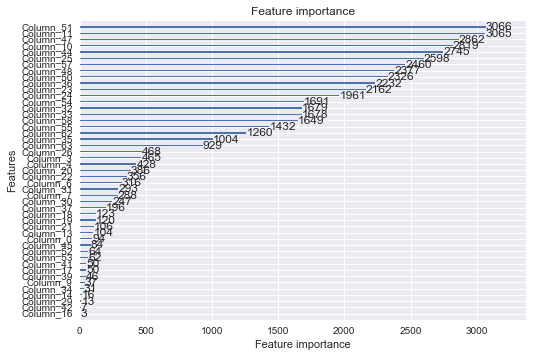

In [26]:
# Convert dataset
d_train = lgb.Dataset(X_train, label=y_train.ravel())

# Set parameters
params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.0021 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['sub_feature'] = 0.5      # feature_fraction -- OK, back to .5, but maybe later increase this
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 5
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

# Train model
# Train model
clf = lgb.train(params, 
               d_train,
               500)

# Plot importance
lgb.plot_importance(clf)
plt.show()

## Step 8: Build and test multiple models
1. If the data is huge, you may want to sample smaller training sets so you can train many different models in a reasonable time (be aware that this penalizes complex models such as large neural nets or Random Forests).
2. Train many quick and dirty models from different categories (e.g., linear, naive Bayes, SVM, Random Forests, neural net, etc.) using standard parameters.
3. Measure and compare their performance.
    * For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds.
4. Analyze the most significant variables for each algorithm.
5. Analyze the types of errors the models make.
    * What data would a human have used to avoid these errors?
6. Have a quick round of feature selection and engineering.
7. Have one or two more quick iterations of the five previous steps.
8. Short-list the top three to five most promising models, preferring models that make different types of errors.
9. Cross-validate each model (a good tutorial for cross-validating neural nets can be found [here](https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/))
10. Tune our parameters to improve our CV scores. Note that you should not tune your parameters using your test set; doing so will leak information to your model that will reduce it's ability to deliver accurate predictions.

### Introduction to Decision Trees, Random Forests, and Gradient Boosted Machines (GBMs)

Key concepts:
    * Decision trees
    * Bagging (ensembling multiple trees together to reduce variance)
    * Random Forests (randomly selecting features out of your feature set)
    * Boosting (using weak learners to learn from misclassified training samples and reduce bias)
    
Helpful visuals [here](http://xgboost.readthedocs.io/en/latest/model.html).

### LightGBM

Recently released into the open source community by Microsoft, LightGBM is a fast, distributed, high performance gradient boosting (GBDT, GBRT, GBM or MART) framework. Here, we cross-validate our previously-trained model and generate predictions.

In [27]:
# Build model with 10-fold CV
clf_cv = lgb.cv(params, 
                d_train, 
                500, 
                nfold = 10, 
                early_stopping_rounds = 100,
                stratified = True)

# Generate predictions
lgbm_pred = clf.predict(X_test, num_iteration=clf.best_iteration)

C:\Users\nthor\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


### K-Fold Cross-Validation of XGBoost

XGBoost was originally created to detect the Higgs boson particle. Let's see how it performs for our dataset.

In [28]:
# Define datasets
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

# Define learning parameters
params = {}
params['eta'] = 0.02
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['silent'] = 1

# Run algo
watchlist = [(d_train, 'train'), (d_test, 'valid')]
clf_xgb = xgb.train(params, 
                    d_train, 
                    10000, 
                    watchlist, # computes both in-sample and out-of-sample errors
                    early_stopping_rounds=100, # quit training after accuracy metric hasn't improved in x rounds
                    verbose_eval=500)

# Make predictions
xgboost_pred = clf_xgb.predict(d_test)

[0]	train-mae:0.697392	valid-mae:0.693324
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
Stopping. Best iteration:
[261]	train-mae:0.419501	valid-mae:0.42209



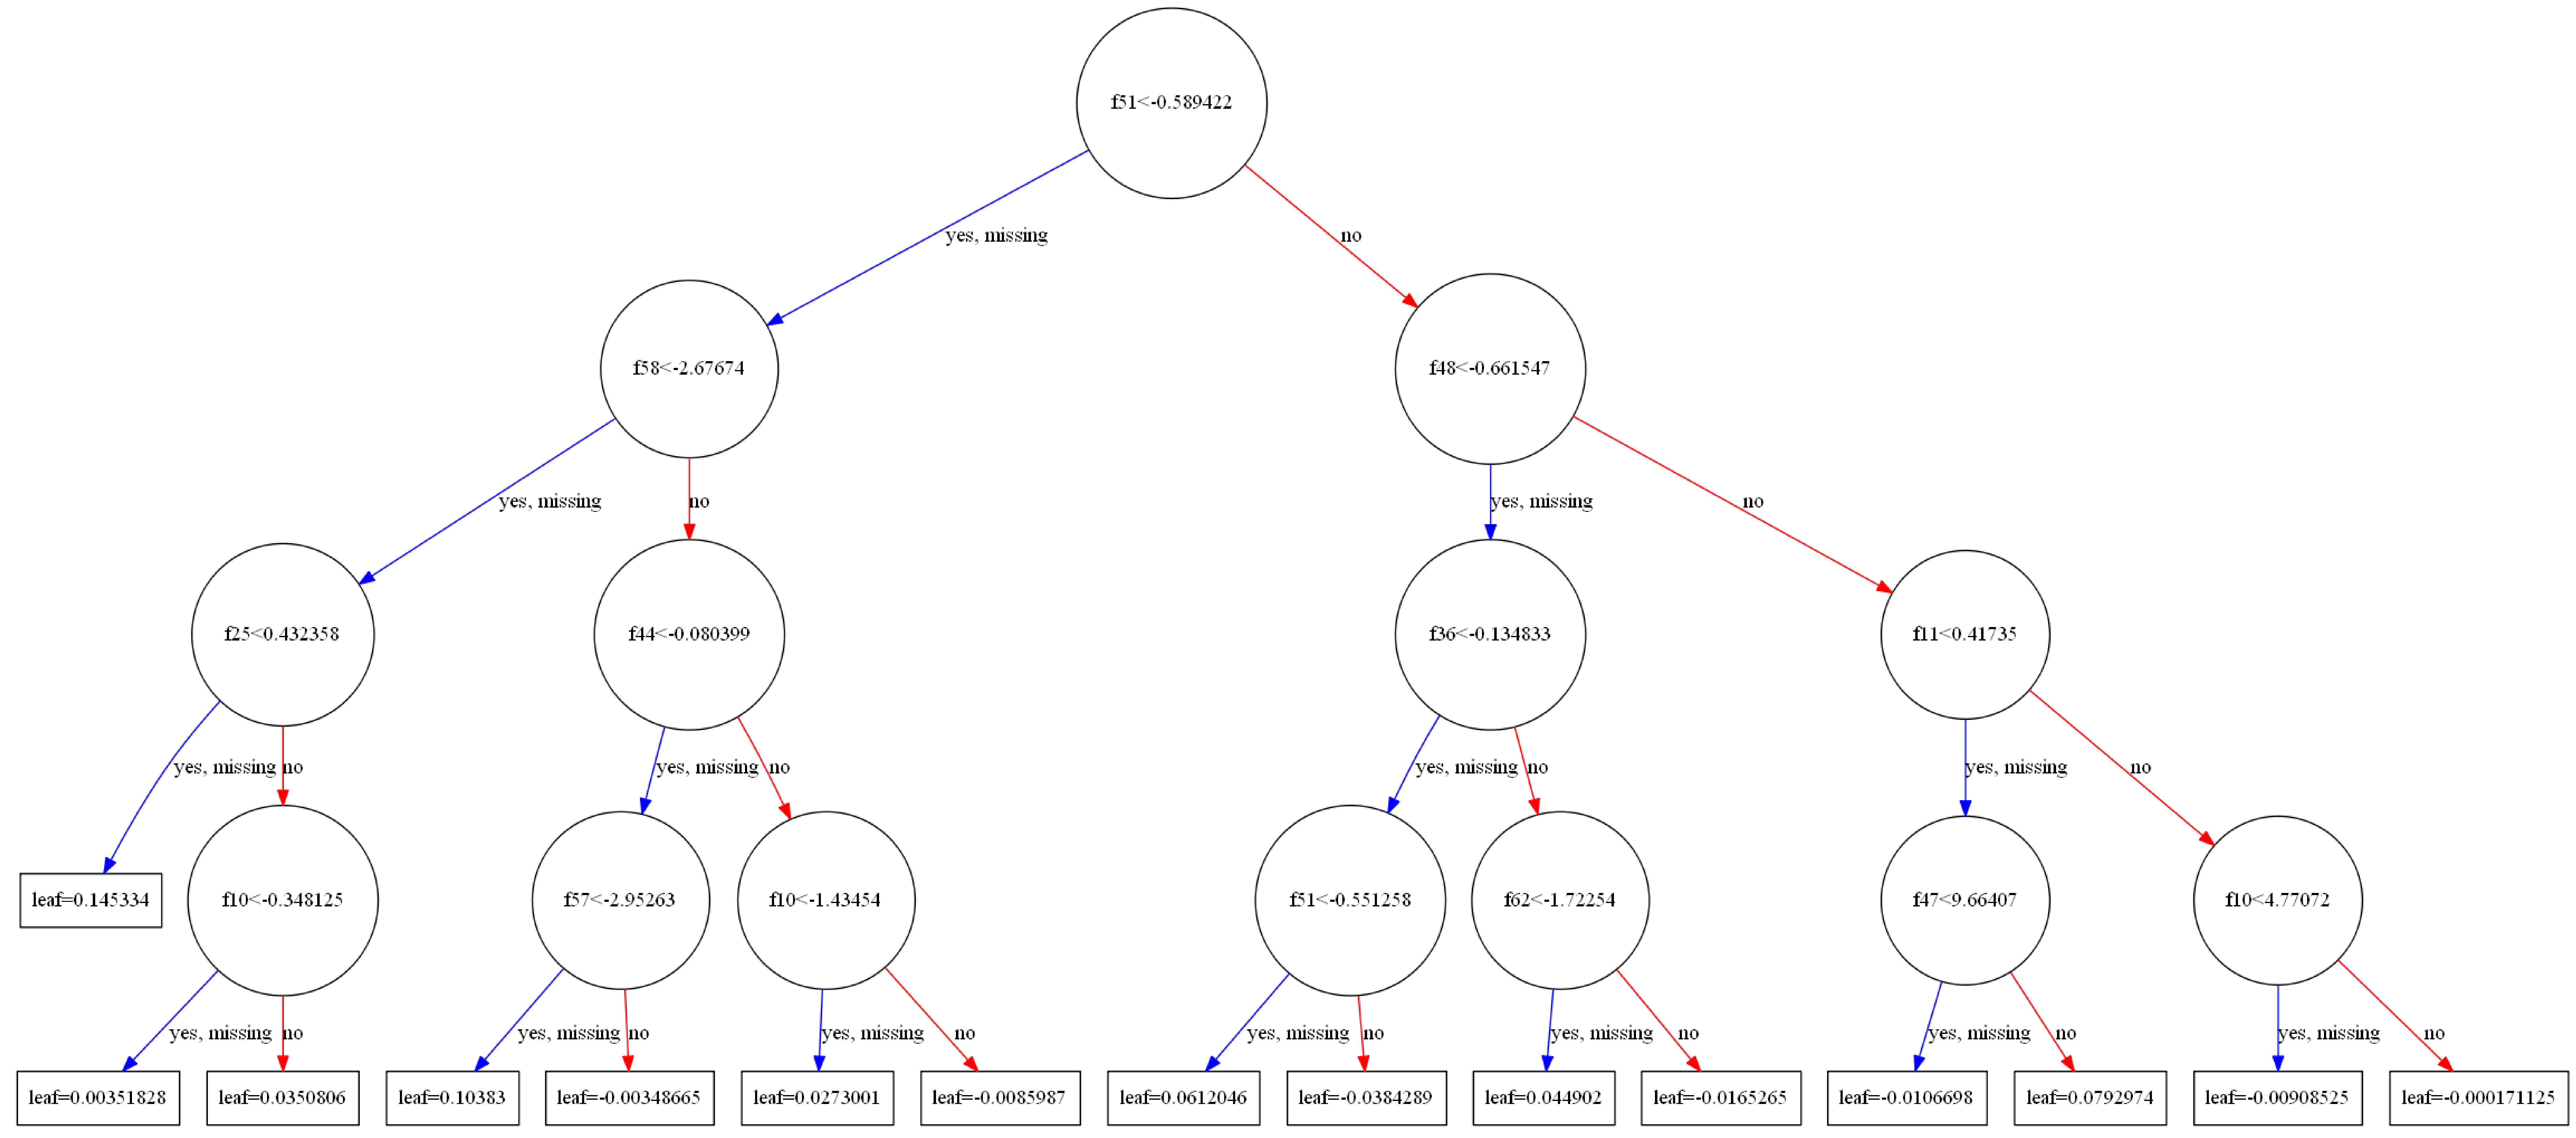

In [29]:
#xgb.plot_importance(clf_xgb)
xgb.plot_tree(clf_xgb)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')
plt.show()

### Building Neural Nets in Keras

Here, we build a function to return the error score of a multilayer ANN in Keras (uses TensorFlow library).

In [54]:
from keras import optimizers

# Set dimension
dim = X_train.shape[1]
    
# Create model
model = Sequential()
model.add(Dense(16, kernel_initializer ='normal', input_dim = dim))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(16, kernel_initializer = 'normal'))
model.add(Activation('relu'))
model.add(Dense(16, kernel_initializer = 'normal'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(1, kernel_initializer ='normal'))
model.add(Activation('sigmoid'))

# Set optimizer and learning rate
adam = optimizers.Adam(lr=.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# Compile model
model.compile(loss='mean_absolute_error', optimizer=adam, metrics = ['mae'])

# Fit the model
model.fit(X_train, y_train, epochs=10, shuffle = True, batch_size = 32)

# Evaluate the model
scores = model.evaluate(X_train, y_train, verbose = 2)

# Generate predictions
nn_pred = model.predict(x = X_test)

Epoch 1/10
72220/72220 [==============================] - 3s - loss: 0.4257 - mean_absolute_error: 0.4257     
Epoch 2/10
72220/72220 [==============================] - 3s - loss: 0.4255 - mean_absolute_error: 0.4255     
Epoch 3/10
72220/72220 [==============================] - 3s - loss: 0.4255 - mean_absolute_error: 0.4255     
Epoch 4/10
72220/72220 [==============================] - 3s - loss: 0.4255 - mean_absolute_error: 0.4255     
Epoch 5/10
72220/72220 [==============================] - 3s - loss: 0.4255 - mean_absolute_error: 0.4255     - ETA: 1s - loss: 0
Epoch 6/10
72220/72220 [==============================] - 3s - loss: 0.4255 - mean_absolute_error: 0.4255     
Epoch 7/10
72220/72220 [==============================] - 3s - loss: 0.4255 - mean_absolute_error: 0.4255     
Epoch 8/10
72220/72220 [==============================] - 2s - loss: 0.4255 - mean_absolute_error: 0.4255     
Epoch 9/10
72220/72220 [==============================] - 2s - loss: 0.4255 - mean_absolute_e

TODO: Increase training epochs (takes more time) and employ K-fold cross-validation to test error.

### General Modeling Improvements
* Get more training examples
* Use a smaller, better set of features
* Try gathering additional features
* Add polynomial features / interaction terms
* Changing regularization term (Lambda)

## Step 9: Ensembling / Stacking
To squeeze every last bit of juice out of our models, we'd want to ensemble our various predictions to both:
* Reduce bias
* Reduce variance

This approach works best when combining a variety of learning algorithms that have different implicit assumptions and, ideally, which were trained on different sets of features. Here's a visual to describe this approach:
![stacknet](http://5047-presscdn.pagely.netdna-cdn.com/wp-content/uploads/2017/06/image8.jpg "StackNet Example")

This type of engineering is generally not used in the business world for a few key reasons:
* Ensembling multiple models takes a significant amount of processing & engineering time
* The net impact is often < 1% improvement, which rarely makes sense in a business context
* Data scientists usually have other, more interesting problems to work on

A simple solution: take the average of your various prediction sets and call it a day.

## Step 10: Finalize Outputs & Present Solution
* Transform data back into original scale (can use scaler.inverse_transform)
* Compare predictions to actual test values
* Calculate interpretable error term (i.e., MAPE)
* Use predictions to drive business decisions. Done!